## 🚀 Guia Rápido de Execução

**Antes de executar este notebook:**

1. **Inicie o LocalStack** (necessário para salvar no S3 local):
   ```bash
   cd docker
   docker-compose up -d localstack
   ```

2. **Verifique se está rodando**:
   ```bash
   docker ps
   ```
   Você deve ver o container `fake-news-localstack`

3. **Execute as células em ordem** (Shift+Enter em cada uma)

---

# Treinamento de Modelo para Detecção de Fake News

Este notebook realiza o treinamento dos modelos de machine learning para detecção de fake news e exporta os modelos treinados para o sistema de armazenamento S3.

In [1]:
# Importações necessárias
import pandas as pd
import numpy as np
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score, GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from IPython.display import display

# Configurações de visualização
plt.rcParams['figure.figsize'] = (10, 6)
sns.set_style("whitegrid")

print("Notebook de Treinamento - Random Forest")
print("="*50)

Notebook de Treinamento - Random Forest


## 1. Carregamento dos Dados de Treino

Vamos carregar os dados que foram pré-processados no notebook 01.

In [2]:
# Carregar dados de treino e teste preparados no notebook 01
print("Carregando dados de treino...")
print("="*40)

# Caminhos dos arquivos
data_dir = "../data/processed"
X_train_path = f"{data_dir}/X_train_fakebr.csv"
X_test_path = f"{data_dir}/X_test_fakebr.csv" 
y_train_path = f"{data_dir}/y_train_fakebr.csv"
y_test_path = f"{data_dir}/y_test_fakebr.csv"

# Verificar se os arquivos existem
required_files = [X_train_path, X_test_path, y_train_path, y_test_path]
missing_files = [f for f in required_files if not os.path.exists(f)]

if missing_files:
    print(f"Arquivos faltando: {missing_files}")
    print("Execute primeiro o notebook 01_preprocess_fakebr.ipynb")
else:
    # Carregar os dados
    X_train = pd.read_csv(X_train_path)
    X_test = pd.read_csv(X_test_path)
    y_train = pd.read_csv(y_train_path)['REAL']  # Extrair a coluna REAL
    y_test = pd.read_csv(y_test_path)['REAL']
    
    print("Dados carregados com sucesso!")
    print(f"Treino: {X_train.shape[0]} amostras x {X_train.shape[1]} features")
    print(f"Teste: {X_test.shape[0]} amostras x {X_test.shape[1]} features")
    print(f"Distribuição do treino: {y_train.value_counts().to_dict()}")
    print(f"Distribuição do teste: {y_test.value_counts().to_dict()}")

    # Mostrar algumas features
    print(f"\nPrimeiras features: {list(X_train.columns[:5])}...")
    print(f"Total de features numéricas: {X_train.shape[1]}")

Carregando dados de treino...
Dados carregados com sucesso!
Treino: 5760 amostras x 21 features
Teste: 1440 amostras x 21 features
Distribuição do treino: {0: 2880, 1: 2880}
Distribuição do teste: {0: 720, 1: 720}

Primeiras features: ['n_tokens', 'n_palavras_sem_pontuacao', 'n_tipos', 'n_links_na_noticia', 'n_palavras_maiusculas']...
Total de features numéricas: 21
Dados carregados com sucesso!
Treino: 5760 amostras x 21 features
Teste: 1440 amostras x 21 features
Distribuição do treino: {0: 2880, 1: 2880}
Distribuição do teste: {0: 720, 1: 720}

Primeiras features: ['n_tokens', 'n_palavras_sem_pontuacao', 'n_tipos', 'n_links_na_noticia', 'n_palavras_maiusculas']...
Total de features numéricas: 21


## 2. Treinamento do Random Forest (Baseline)

Vamos começar com um Random Forest simples, com parâmetros padrão, para estabelecer uma baseline.

In [3]:
# Criar o modelo Random Forest com parâmetros padrão
print("Criando Random Forest baseline...")
print("="*40)

# Inicializar o modelo
rf_model = RandomForestClassifier(
    random_state=42,  # Para reprodutibilidade
    n_jobs=-1        # Usar todos os cores disponíveis
)

print("Modelo criado!")
print(f"Parâmetros padrão:")
print(f"   - n_estimators: {rf_model.n_estimators} árvores")
print(f"   - max_depth: {rf_model.max_depth} (sem limite)")
print(f"   - min_samples_split: {rf_model.min_samples_split}")
print(f"   - min_samples_leaf: {rf_model.min_samples_leaf}")

# Treinar o modelo
print(f"\nTreinando o modelo...")
rf_model.fit(X_train, y_train)
print("Treinamento concluído!")

Criando Random Forest baseline...
Modelo criado!
Parâmetros padrão:
   - n_estimators: 100 árvores
   - max_depth: None (sem limite)
   - min_samples_split: 2
   - min_samples_leaf: 1

Treinando o modelo...
Treinamento concluído!
Treinamento concluído!


## 3. Avaliação do Modelo - Métricas Básicas

Agora vamos fazer predições e calcular as métricas de desempenho.
Métricas utilizadas:

Acurácia: Porcentagem de acertos totais.

ROC-AUC: Mede a capacidade do modelo de separar as classes usando probabilidades. [0,1]



In [4]:
# Fazer predições
print("Fazendo predições...")
print("="*40)

# Predições no conjunto de treino (para verificar overfitting)
y_train_pred = rf_model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)

# Predições no conjunto de teste (performance real)
y_test_pred = rf_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Probabilidades (para ROC-AUC)
y_test_proba = rf_model.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, y_test_proba)

print(f"Predições concluídas!")
print(f"\nResultados:")
print(f"   Acurácia Treino: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
print(f"   Acurácia Teste:  {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"   ROC-AUC:         {test_auc:.4f}")

# Verificar overfitting
diff = train_accuracy - test_accuracy
if diff > 0.05:
    print(f"\nPossível overfitting detectado (diferença: {diff:.4f})")
else:
    print(f"\nModelo generaliza bem (diferença: {diff:.4f})")

Fazendo predições...
Predições concluídas!

Resultados:
   Acurácia Treino: 1.0000 (100.00%)
   Acurácia Teste:  0.9861 (98.61%)
   ROC-AUC:         0.9945

Modelo generaliza bem (diferença: 0.0139)


### Métricas utilizadas no classification_report:

Precision: Das notícias que o modelo disse ser REAL, quantas realmente eram?

Recall: De todas as notícias REAIS, quantas o modelo conseguiu encontrar?

F1-Score: Média harmônica entre Precision e Recall. (F1 alto = modelo balanceado; F1 baixo = modelo ruim em algo (precision ou recall))

Support: quantas amostras dessa classe existem no teste

Médias (macro e weighted): macro avg: Média simples das métricas (trata classes igualmente); weighted avg: Média ponderada pelo support (considera desbalanceamento)

In [6]:
# Relatório de classificação detalhado
print("\nRelatório de Classificação:")
print("="*50)
print(classification_report(y_test, y_test_pred, 
                          target_names=['Fake (0)', 'Real (1)'],
                          digits=4))


Relatório de Classificação:
              precision    recall  f1-score   support

    Fake (0)     0.9861    0.9861    0.9861       720
    Real (1)     0.9861    0.9861    0.9861       720

    accuracy                         0.9861      1440
   macro avg     0.9861    0.9861    0.9861      1440
weighted avg     0.9861    0.9861    0.9861      1440



## 4. Matriz de Confusão

A matriz de confusão mostra onde o modelo está acertando e errando.

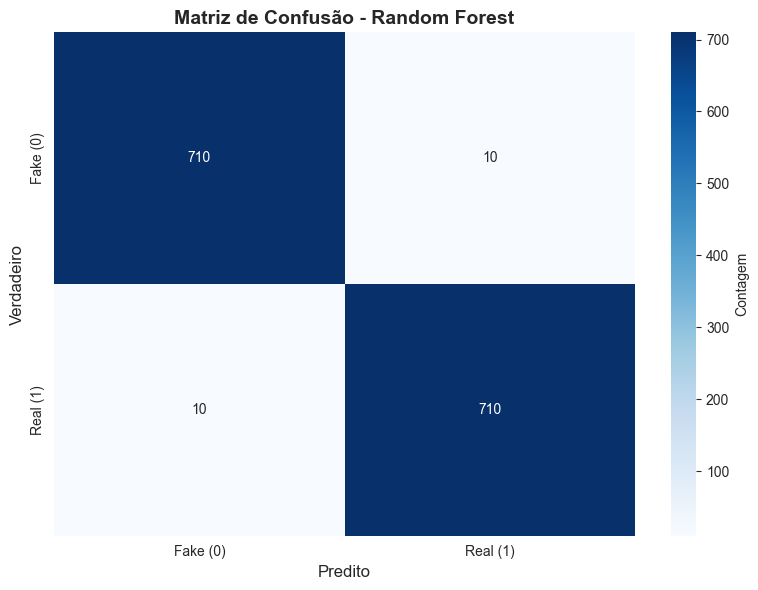


Interpretação da Matriz:
Verdadeiros Negativos (TN): 710 - Fake predito como Fake ✅
Falsos Positivos (FP):      10 - Fake predito como Real ❌
Falsos Negativos (FN):      10 - Real predito como Fake ❌
Verdadeiros Positivos (TP): 710 - Real predito como Real ✅


In [7]:
# Calcular matriz de confusão
cm = confusion_matrix(y_test, y_test_pred)

# Visualizar matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Fake (0)', 'Real (1)'],
            yticklabels=['Fake (0)', 'Real (1)'],
            cbar_kws={'label': 'Contagem'})
plt.title('Matriz de Confusão - Random Forest', fontsize=14, fontweight='bold')
plt.ylabel('Verdadeiro', fontsize=12)
plt.xlabel('Predito', fontsize=12)
plt.tight_layout()
plt.show()

# Mostrar valores da matriz
print("\nInterpretação da Matriz:")
print("="*50)
print(f"Verdadeiros Negativos (TN): {cm[0,0]} - Fake predito como Fake ✅")
print(f"Falsos Positivos (FP):      {cm[0,1]} - Fake predito como Real ❌")
print(f"Falsos Negativos (FN):      {cm[1,0]} - Real predito como Fake ❌")
print(f"Verdadeiros Positivos (TP): {cm[1,1]} - Real predito como Real ✅")

## 5. Feature Importance (Importância das Features)

Vamos ver quais features linguísticas são mais importantes para detectar fake news.

🔍 Top 15 Features Mais Importantes:


,feature,importance
7,n_substantivos,0.190811
15,n_caracteres,0.142894
0,n_tokens,0.129760
1,n_palavras_sem_pontuacao,0.109269
2,n_tipos,0.107691
3,n_links_na_noticia,0.072537
20,diversidade,0.064676
5,n_verbos,0.051047
9,n_adverbios,0.023837
10,n_verbos_modais,0.021304


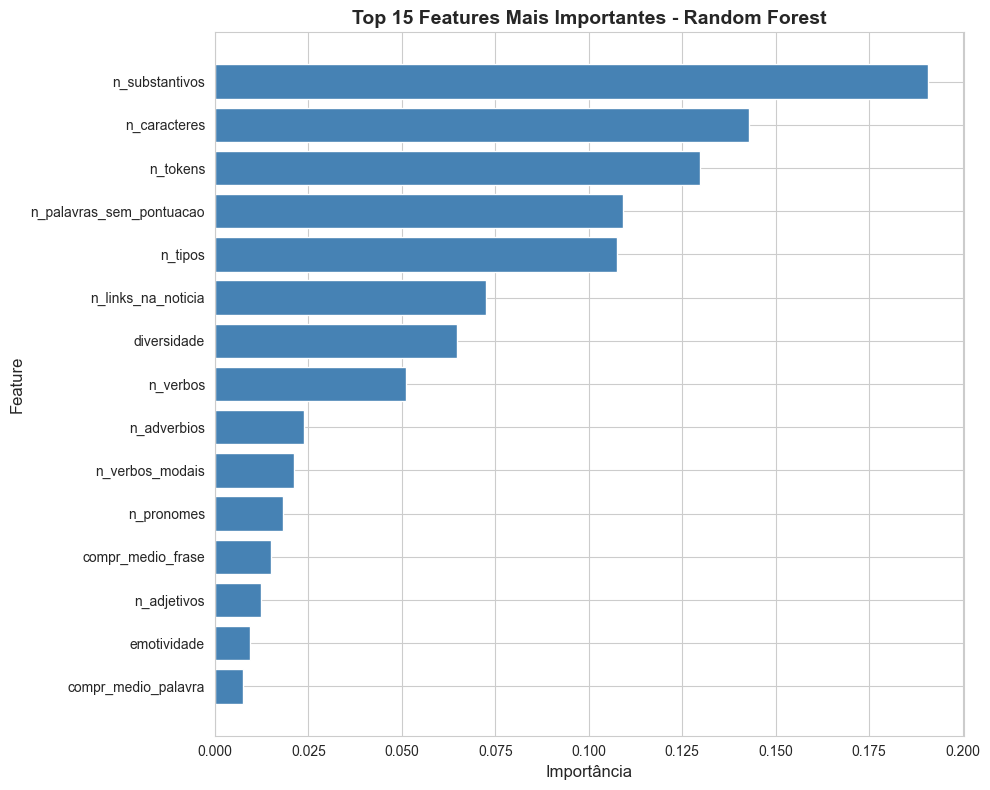


Insight:
As features mais importantes são as que o modelo usa mais para decidir!
Importância total: 1.0000


In [8]:
# Obter importância das features
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

# Mostrar top 15 features
print("🔍 Top 15 Features Mais Importantes:")
print("="*50)
display(feature_importance.head(15))

# Visualizar top 15
plt.figure(figsize=(10, 8))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['importance'], color='steelblue')
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importância', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Top 15 Features Mais Importantes - Random Forest', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()  # Maior no topo
plt.tight_layout()
plt.show()

print(f"\nInsight:")
print(f"As features mais importantes são as que o modelo usa mais para decidir!")
print(f"Importância total: {feature_importance['importance'].sum():.4f}")

## 6. Salvamento do Modelo

Vamos salvar o modelo treinado localmente primeiro.

In [9]:
# Salvar modelo localmente
print("Salvando modelo...")
print("="*40)

# Criar diretório de modelos se não existir
models_dir = "../models"
os.makedirs(models_dir, exist_ok=True)

# Nome do arquivo do modelo
model_filename = f"{models_dir}/random_forest_fakebr.joblib"

# Salvar modelo
joblib.dump(rf_model, model_filename)
print(f"Modelo salvo em: {model_filename}")

# Salvar metadados
metadata = {
    'model_type': 'RandomForestClassifier',
    'dataset': 'FakeBR',
    'train_samples': X_train.shape[0],
    'test_samples': X_test.shape[0],
    'n_features': X_train.shape[1],
    'train_accuracy': float(train_accuracy),
    'test_accuracy': float(test_accuracy),
    'roc_auc': float(test_auc),
    'n_estimators': rf_model.n_estimators,
    'timestamp': pd.Timestamp.now().isoformat()
}

import json
metadata_filename = f"{models_dir}/random_forest_fakebr_metadata.json"
with open(metadata_filename, 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"Metadados salvos em: {metadata_filename}")

print(f"\nResumo Final:")
print(f"   Modelo: Random Forest")
print(f"   Acurácia Teste: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"   ROC-AUC: {test_auc:.4f}")
print(f"   Features: {X_train.shape[1]}")
print(f"\nModelo pronto para uso!")

Salvando modelo...
Modelo salvo em: ../models/random_forest_fakebr.joblib
Metadados salvos em: ../models/random_forest_fakebr_metadata.json

Resumo Final:
   Modelo: Random Forest
   Acurácia Teste: 0.9861 (98.61%)
   ROC-AUC: 0.9945
   Features: 21

Modelo pronto para uso!


## 7. Upload para S3 (LocalStack)

Agora vamos fazer upload do modelo para o S3 local (LocalStack).

**Pré-requisito:** O Docker com LocalStack deve estar rodando!

Para iniciar o LocalStack, rode no terminal:
```bash
cd docker
docker-compose up -d localstack
```

In [ ]:
# Testar conexão com LocalStack S3
import boto3
from botocore.exceptions import ClientError

print("Testando conexão com LocalStack S3...")
print("="*40)

# Configurar cliente S3 para LocalStack
s3_client = boto3.client(
    's3',
    endpoint_url='http://localhost:4566',  # Endpoint do LocalStack
    aws_access_key_id='test',
    aws_secret_access_key='test',
    region_name='us-east-1'
)

try:
    # Tentar listar buckets (testa conexão)
    response = s3_client.list_buckets()
    print("Conexão com LocalStack estabelecida!")
    print(f"Buckets disponíveis: {[b['Name'] for b in response['Buckets']]}")
except Exception as e:
    print(f"Erro ao conectar com LocalStack:")
    print(f"   {e}")
    print("\nCertifique-se que o LocalStack está rodando:")
    print("   cd docker")
    print("   docker-compose up -d localstack")

In [ ]:
# Criar bucket se não existir
bucket_name = 'fake-news-models'

print(f"Verificando bucket '{bucket_name}'...")
print("="*40)

try:
    # Verificar se bucket existe
    s3_client.head_bucket(Bucket=bucket_name)
    print(f"Bucket '{bucket_name}' já existe!")
    
except ClientError as e:
    error_code = e.response['Error']['Code']
    if error_code == '404':
        # Bucket não existe, criar
        print(f"Bucket '{bucket_name}' não existe. Criando...")
        s3_client.create_bucket(Bucket=bucket_name)
        print(f"Bucket '{bucket_name}' criado com sucesso!")
    else:
        print(f"Erro ao verificar bucket: {e}")
        raise

In [ ]:
# Upload do modelo para S3
print("Fazendo upload do modelo para S3...")
print("="*40)

# Definir keys (caminhos) no S3
s3_model_key = f"models/fakebr/random_forest_fakebr_{pd.Timestamp.now().strftime('%Y%m%d_%H%M%S')}.joblib"
s3_metadata_key = f"models/fakebr/random_forest_fakebr_{pd.Timestamp.now().strftime('%Y%m%d_%H%M%S')}_metadata.json"

try:
    # Upload do modelo
    print(f"Uploading modelo: {s3_model_key}")
    s3_client.upload_file(
        Filename=model_filename,
        Bucket=bucket_name,
        Key=s3_model_key
    )
    print("Modelo enviado com sucesso!")
    
    # Upload dos metadados
    print(f"Uploading metadados: {s3_metadata_key}")
    s3_client.upload_file(
        Filename=metadata_filename,
        Bucket=bucket_name,
        Key=s3_metadata_key
    )
    print("Metadados enviados com sucesso!")
    
    # Listar arquivos no bucket para confirmar
    print(f"\nArquivos no bucket '{bucket_name}':")
    response = s3_client.list_objects_v2(Bucket=bucket_name, Prefix='models/fakebr/')
    if 'Contents' in response:
        for obj in response['Contents']:
            size_kb = obj['Size'] / 1024
            print(f"   - {obj['Key']} ({size_kb:.2f} KB)")
    
    print(f"\nUpload completo!")
    print(f"Modelo disponível em: s3://{bucket_name}/{s3_model_key}")
    
except Exception as e:
    print(f"Erro ao fazer upload: {e}")

### ✅ Teste: Baixar e Carregar Modelo do S3

Vamos testar se conseguimos baixar o modelo do S3 e carregá-lo de volta!

In [ ]:
# Baixar modelo do S3 e testar
print("Testando download do S3...")
print("="*40)

# Criar diretório temporário para teste
test_dir = "../models/test_from_s3"
os.makedirs(test_dir, exist_ok=True)

# Path local para salvar o modelo baixado
downloaded_model_path = f"{test_dir}/downloaded_model.joblib"

try:
    # Download do modelo
    print(f"Baixando de: s3://{bucket_name}/{s3_model_key}")
    s3_client.download_file(
        Bucket=bucket_name,
        Key=s3_model_key,
        Filename=downloaded_model_path
    )
    print(f"Modelo baixado para: {downloaded_model_path}")
    
    # Carregar o modelo baixado
    print("\nCarregando modelo baixado...")
    loaded_model = joblib.load(downloaded_model_path)
    print("Modelo carregado com sucesso!")
    
    # Testar o modelo baixado
    print("\nTestando o modelo baixado...")
    test_predictions = loaded_model.predict(X_test[:5])
    print(f"Predições de teste: {test_predictions}")
    
    print("\nTeste completo! O ciclo S3 está funcionando:")
    print("   1. Modelo treinado")
    print("   2. Modelo salvo localmente")
    print("   3. Modelo enviado para S3")
    print("   4. Modelo baixado do S3")
    print("   5. Modelo carregado e testado")
    
except Exception as e:
    print(f"Erro no teste: {e}")